# ApSimX Soil Temperature 

The documentation of the Apsim model is available at: https://www.apsim.info/documentation/model-documentation/soil-modules-documentation/soiltemp/

## Aim
The aim of this Notebook is to describe the model Soil temperature, and design its Python implementation from C# APSIM one.

## Constant

In [6]:
######################## Constant Definition
"""
// NEW
// Two representations are distinguished for the profile.
// a) Soil layers, each with a top and bottom boundary and a depth. Index range of 1..NumLayer
// b) Temperature nodes, each node being at the centre of each layer and additionally a node below
// the bottom layer and a node above the top layer (in the atmosphere). Index range of 0..NumLayer + 1,
// giving 0 for atmosphere,
"""
from math import pi as PI

doInit1Stuff = False      

# latent heat of vapourisation for water (J/kg); 1 mm evap/day = 1 kg/m^2 day requires 2.45*10^6 J/m^2
LAMBDA: float = 2465000.0      

# defines the power per unit area emitted by a black body as a function of its thermodynamic temperature (W/m^2/K^4).   
STEFAN_BOLTZMANNconst : float = 0.0000000567 

# no of days in one year
DAYSinYear : float = 365.25    
DEG2RAD : float = PI / 180.0;
RAD2DEG : float = 180.0 / PI;
DOY2RAD : float = DEG2RAD * 360.0 / DAYSinYear;          # convert day of year to radians
MIN2SEC : float = 60.0;          # 60 seconds in a minute - conversion minutes to seconds
HR2MIN : float = 60.0;           # 60 minutes in an hour - conversion hours to minutes
SEC2HR : float = 1.0 / (HR2MIN * MIN2SEC);  # conversion seconds to hours
DAYhrs : float  = 24.0;           # hours in a day
DAYmins : float = DAYhrs * HR2MIN;           # minutes in a day
DAYsecs : float = DAYmins * MIN2SEC;         # seconds in a day
M2MM : float = 1000.0;           # 1000 mm in a metre -  conversion Metre to millimetre
MM2M : float = 1 / M2MM;           # 1000 mm in a metre -  conversion millimetre to Metre
PA2HPA : float = 1.0 / 100.0;        # conversion of air pressure pascals to hectopascals
MJ2J : float = 1000000.0;            # convert MJ to J
J2MJ : float = 1.0 / MJ2J;            # convert J to MJ
AIRnode : int = 0;                # index of atomspheric node
SURFACEnode : int = 1;            # index of surface node
TOPSOILnode : int = 2;            # index of first soil layer node

# Internal Data
"""
        private double gDt = 0.0;             // Internal timestep in seconds.
        private double timeOfDaySecs = 0;     // Time of day in seconds from midnight.
        private int numNodes = 0;             // number of nodes
        private int numLayers = 0;            // number of soil layers in profile
        private double[] thermCondPar1;       // soil solids thermal conductivity parameter
        private double[] thermCondPar2;       // soil solids thermal conductivity parameter
        private double[] thermCondPar3;       // soil solids thermal conductivity parameter
        private double[] thermCondPar4;       // soil solids thermal conductivity parameter
        private double[] volSpecHeatSoil;     // Joules/m^3/K
        private double[] soilTemp;            // soil temperature
        private double[] morningSoilTemp;     // soil temperature
        private double[] heatStorage;         // CP; heat storage between nodes - index is same as upper node (J/s/K or W/K)
        private double[] thermalConductance;  // K; conductance of element between nodes - index is same as upper node
        private double[] thermalConductivity; // thermal conductivity (W/m^2/K)
        private int boundaryLayerConductanceIterations = 0;  // Number of iterations to calculate atmosphere boundary layer conductance
        private double _boundaryLayerConductance = 0.0;      // Average daily atmosphere boundary layer conductance
        private double[] tempNew;             // soil temperature at the end of this iteration (oC)
        private double[] depth;               // node depths - get from water module, metres
        private double airTemp = 0.0;         // Air temperature (oC)
        private double maxAirTemp = 0.0;      // Max daily Air temperature (oC)
        private double minAirTemp = 0.0;      // Min daily Air temperature (oC)
        private double maxTempYesterday = 0.0;
        private double minTempYesterday = 0.0;
        private double[] soilWater;           // volumetric water content (cc water / cc soil)
        private double[] minSoilTemp;         // minimum soil temperature (oC)
        private double[] maxSoilTemp;         // maximum soil temperature (oC)
        private double tempStepSec = 0.0;     // this will be set to timestep * 60 at the beginning of each calc. (seconds)
        private double[] bulkDensity;         // bd (soil bulk density) is name of the APSIM var for bulk density so set bulkDensity = bd later (g/cc)
        private double[] thickness;           // APSIM soil layer depths as thickness of layers (mm)
        private double instrumentHeight = 0.0;// (m) height of instruments above soil surface
        private double airPressure = 0.0;     // (hPa) Daily air pressure
        private double windSpeed = 0.0;       // (km) daily wind run
        private double potSoilEvap = 0.0;     // (mm) pot sevap after modification for green cover residue wt
        private double potEvapotrans = 0.0;   // (mm) pot evapotranspitation
        private double actualSoilEvap = 0.0;  // actual soil evaporation (mm)
        private double netRadiation = 0.0;    // Net radiation per internal timestep (MJ)
        private double canopyHeight = 0.0;    // (m) height of canopy above ground
        private double soilRoughnessHeight = 0.0;    // (mm) height of soil roughness
        private double[] clay;                // Proportion of clay in each layer of profile (0-1)
        #endregion
"""


'\n        private double gDt = 0.0;             // Internal timestep in seconds.\n        private double timeOfDaySecs = 0;     // Time of day in seconds from midnight.\n        private int numNodes = 0;             // number of nodes\n        private int numLayers = 0;            // number of soil layers in profile\n        private double[] thermCondPar1;       // soil solids thermal conductivity parameter\n        private double[] thermCondPar2;       // soil solids thermal conductivity parameter\n        private double[] thermCondPar3;       // soil solids thermal conductivity parameter\n        private double[] thermCondPar4;       // soil solids thermal conductivity parameter\n        private double[] volSpecHeatSoil;     // Joules/m^3/K\n        private double[] soilTemp;            // soil temperature\n        private double[] morningSoilTemp;     // soil temperature\n        private double[] heatStorage;         // CP; heat storage between nodes - index is same as upper node (

In [7]:
timestep:int = 1440;     # timestep in minutes

# this was not an input in old apsim. # [Input]    #FIXME - optional input
maxTempTime :float= 0.0;      # Time of maximum temperature in hours

instrumHeight:float = 0.0;    # (m) height of instruments above ground

altitude : float= 0.0;         # (m) altitude at site

nu :float= 0.6;                # forward/backward differencing coefficient (0-1).
                          # A weighting factor which may range from 0 to 1. If nu=0, the flux is determined by the temperature difference
                          # at the beginning of the time step. The numerical procedure which results from this choice is called a forward
                          # difference of explicit method. If nu=0.5, the average of the old and new temperatures is used to compute heat flux.
                          # This is called a time-centered or Crank-Nicholson scheme.
                          # The equation for computing T(j+1) is implicit for this choice of nu (and any other except nu=0) since T(j+1) depends
                          # on the values of the new temperatures at the nodes i+1 and i-1. Most heat flow models use either nu=0 or nu=0.5.
                          # The best value for nu is determined by consideration of numerical stability and accuracy.
                          # The explicit scheme with nu=0 predicts more heat transfer between nodes than would actually occur, and can therefore
                          # become unstable if time steps are too large. Stable numerical solutions are only obtained when (Simonson, 1975)
                          # deltaT < CH*(deltaZ)^2 / 2*lambda.
                          # When nu < 0.5, stable solutions to the heat flow problem will always be obtained, but if nu is too small, the solutions
                          # may oscillate. The reason for this is that the simulated heat transfer between nodes overshoots. On the next time step
                          # the excess heat must be transferrec back, so the predicted temperature at that node oscillates. On the other hand, if nu
                          # is too large, the temperature difference will be too small and not enough heat will be transferred. Simulated temperatures
                          # will never oscillate under these conditions, but the simulation will understimate heat flux. The best accuracy is obtained
                          # with nu around 0.4, while best stability is at nu=1. A typical compromise is nu=0.6.


volSpecHeatClay:float = 2.39e6;  # [Joules*m-3*K-1]

volSpecHeatOM:float = 5e6;       # [Joules*m-3*K-1]

volSpecHeatWater:float = 4.18e6; # [Joules*m-3*K-1]

maxTTimeDefault:float = 14.;


boundarLayerConductanceSource:str = "calc";

boundaryLayerConductance: float = 20.;

BoundaryLayerConductanceIterations : int = 1;    # maximum number of iterations to calculate atmosphere boundary layer conductance

netRadiationSource: str = "calc";

        # from met
defaultWindSpeed: float = 3.;      # default wind speed (m/s)

defaultAltitude: float = 18;    # default altitude (m)
defaultInstrumentHeight: float = 1.2;  # default instrument height (m)

bareSoilHeight: float = 57;        # roughness element height of bare soil (mm)


## Outputs
* FinalSoilTemp : List(float) size [numLayers]
* FinalSoilSurfaceTemp = soilTemp[SURFACEnode]
* AverageSoilTemp : List(float)
* AverageSoilSurfaceTemp : float
* MinSoilTemp : List(float)
* MinSoilSurfaceTemp : float
* MaxSoilTemp : List(float)
* MaxSoilSurfaceTemp : float
* BoundaryLayerConductance: float
* ThermalConductivity : List(float)
* HeatCapacity : List(float)
* HeatStore : List(float)




## Algorithm

### Init soil

Calculate Initial Soil Temperature: 

$$T_{avg} = \frac{T_{min} + T_{max}}{2}$$

**Initial Surface Temperature**



$$
\begin{align}
T_{surface}^{init} = (1 - S_{albedo})&&   (T_{avg} + (T_{max} - T_{avg}) \sqrt{\frac{Radiation_{net} * 23.8846}{800.0}})  \\
+ S_{albedo} T_{avg} &&  
\end{align} 
$$

**Initial Soil Temperature**

Use of EPIC Model

Set the surface temperature based on a sinusoidal function :

$$T_{avg}+T_{amp} \exp({-\frac{z}{z_d}}) \sin(\omega t - \frac{z}{z_d})$$

But in the implementation it is:

$$T_{avg}+\frac{T_{amp}}{2} \exp({-\frac{z}{z_d}}) (\cos(\omega t - \frac{z}{z_d}) + \Delta T) $$



In [1]:
def init():
    """Init of the soil temperature model"""
    
    # 1. Surface Temperature 
        # Surface Albedo, Air Temperature (min, max), Net Radiation
    # 2. Initial Soil Temperature

# TODO

** TOCHECK **

    SABD : Soil albedo set to 0.13 
    RADN : Net Radiation = 11 

# Thomas algorithm 

The Tridiagonla Matrix algorithm is also known as the Thomas algorithm.
This is a simplification of a Gaussian elimination algo. in $O(n)$ rather than $O(n^3)$

You can find the math here: http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm

The algorithm is the following

$$
\begin{bmatrix} 
    b_1 & c_1 & 0 & & \\
	a_2 & b_2 & c_2& & \\
	&a_3 & b_3 & c_3&  \\
	 &  & & &c_{NZ-1} \\
	0 & ... & & a_{NZ}& b_{NZ}\\
\end{bmatrix}
\begin{bmatrix} 
    T_1^{j+1} \\
    T_2^{j+1} \\
    T_3^{j+1} \\
    ... \\
    T_{NZ}^{j+1} \\
\end{bmatrix}
=
\begin{bmatrix} 
    d_1 \\
    d_2 \\
    d_3 \\
    ... \\
    d_{NZ} \\
\end{bmatrix}
\quad
$$

if you set
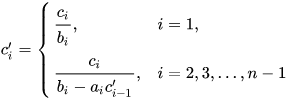

and 
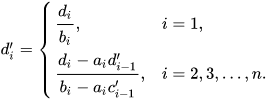

The solution is then obtained by back substitution :

$$
\begin{array}{lcl}
T_{NZ} & = & d^{'}_{NZ} &\\
T_i & = &  d^{'}_{i} - c^{'}_i T_{i+1} & i = NZ-i, ..., 1\\
\end{array}
$$

In [6]:
def ThomasSolver(a, b, c, d):
    '''
    Thomas solver, a b c d are Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    
    This is a modify version of https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9
    
    a, b, c, d are list of size n
    return t of same size (the solution).
    '''
    n = len(d) # number of equations
    a, b, c, d = map(list, (a, b, c, d)) # copy lists
    for i in range(1, n):
        m = a[i]/b[i-1]
        b[i] = b[i] - m*c[i-1] 
        d[i] = d[i] - m*d[i-1]
       
    t = b
    t[-1] = d[-1]/b[-1]

    for i in range(n-2, -1, -1):
        t[i] = (d[i]-c[i]*t[i+1])/b[i]

    return t


In [9]:
import numpy as np

A = np.array([[10,2,0,0],[3,10,4,0],[0,1,7,5],[0,0,3,4]],dtype=float)

a = [0, 3.,1,3] 
b = [10.,10.,7.,4.]
c = [2.,4.,5., 0]
d = [3,4,5,6.]

print ('T solver : ', ThomasSolver(a, b, c, d))
print ('Numpy Solver ', np.linalg.solve(A, d))


T solver :  [0.1487758945386064, 0.756120527306968, -1.001883239171375, 2.2514124293785316]
Numpy Solver  [ 0.14877589  0.75612053 -1.00188324  2.25141243]


In [10]:
%timeit ThomasSolver(a, b, c, d)

4.02 µs ± 11.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%timeit np.linalg.solve(A, d)

12.4 µs ± 77.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
